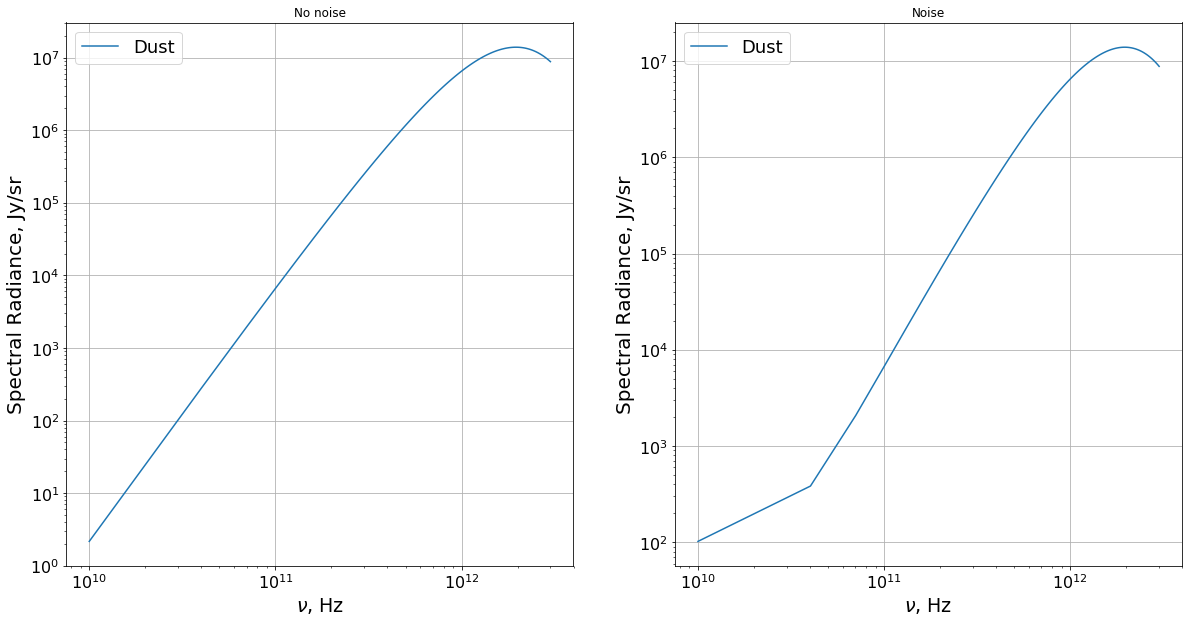

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from numpy.polynomial.polynomial import Polynomial
from scipy.interpolate import lagrange #Lagrange 
from scipy.optimize import curve_fit

A_D = 1.36 * 10**6   # Константы из статьи
beta_D = 1.53
T_D = 21

param = np.array([T_D, A_D, beta_D])

h = 6.626 * 10**(-34)  # Мировые константы
k = 1.381 * 10**(-23)

def Thermal_Dust(nu):  # Спектр пыли
    x = (h * nu)/(k * T_D)
    I = A_D * x**beta_D * (x**3)/(np.exp(x) - 1)
    return I
    
x = np.linspace(10**10, 3 * 10**12, 100)
I = Thermal_Dust(x)
noise = np.random.normal(loc = 10**10, scale = 50, size = 100)

fig = plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.title('No noise')
plt.loglog(x, I, label = 'Dust')
plt.xlabel('$\\nu$, Hz', fontsize=19)
plt.ylabel('Spectral Radiance, Jy/sr', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize = 18)
plt.grid()

plt.subplot(122)
plt.title('Noise')
plt.loglog(x, I + noise * 10**(-8), label = 'Dust')
plt.xlabel('$\\nu$, Hz', fontsize=19)
plt.ylabel('Spectral Radiance, Jy/sr', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize = 18)
plt.grid()



# Пыль с шумом

[2.10002785e+01 1.36012487e+06 1.52994295e+00]
[2.10e+01 1.36e+06 1.53e+00]
Относительная ошибка [1.3261579251125763e-05, 9.18157000986599e-05, 3.728532914514125e-05]


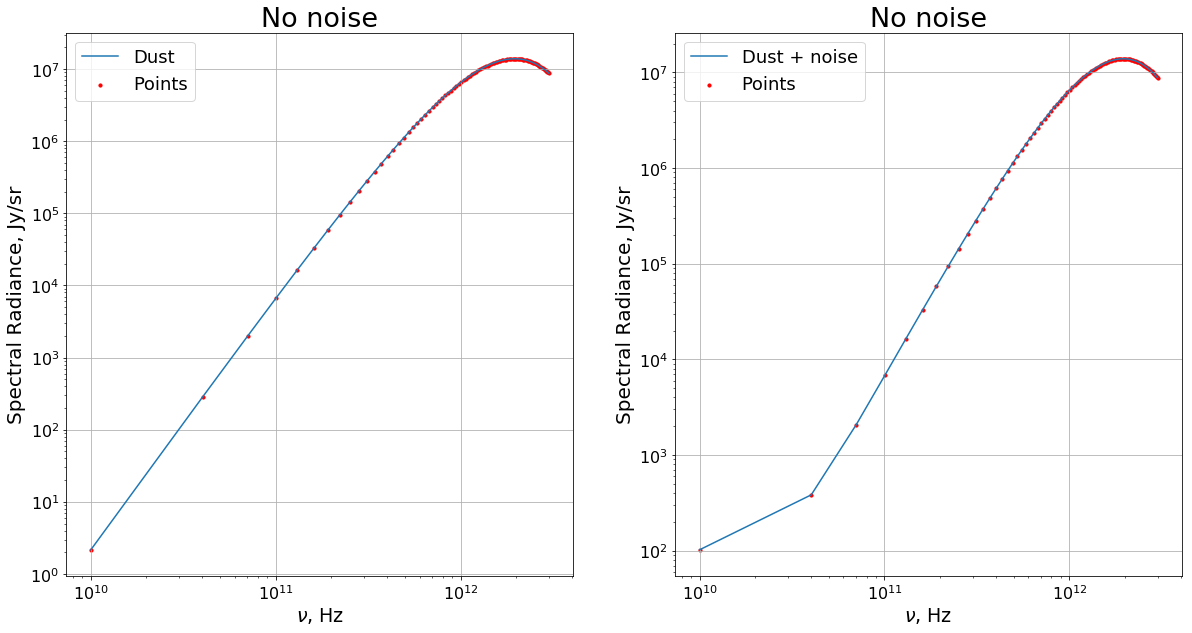

In [3]:
def Thermal_Dust_param(nu, T_D, A_D, beta_D):  # Спектр пыли c параметрами
    x = (h * nu)/(k * T_D)
    I = A_D * x**beta_D * (x**3)/(np.exp(x) - 1)
    return I

x = np.linspace(10**10, 3 * 10**12, 100)
I = Thermal_Dust(x)
I_noise = I + noise * 10**(-8)
fig = plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.loglog(x, I, label = 'Dust')
plt.scatter(x, I, label = 'Points', s = 10, c = 'r')
plt.title('No noise', fontsize = 27)
plt.xlabel('$\\nu$, Hz', fontsize=19)
plt.ylabel('Spectral Radiance, Jy/sr', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize = 18)
plt.grid()

plt.subplot(122)
plt.loglog(x, I_noise, label = 'Dust + noise')
plt.scatter(x, I_noise, label = 'Points', s = 10, c = 'r')
plt.title('No noise', fontsize = 27)
plt.xlabel('$\\nu$, Hz', fontsize=19)
plt.ylabel('Spectral Radiance, Jy/sr', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize = 18)
plt.grid()

popt, pcov = curve_fit(Thermal_Dust_param, x, I_noise)
print(popt)
print(param)
dev = list(abs(popt - param))
eps = [dev / (list(param))[n] for n, dev in enumerate(dev)]
print('Относительная ошибка', eps)

# Пыль и $\mu$ - возмущение

[2.1000000e+01 1.3600000e+06 1.5300000e+00 2.0000001e-08]
[2.10e+01 1.36e+06 1.53e+00 2.00e-08]
Относительная ошибка [1.8778629445088362e-14, 1.1418973479200812e-13, 5.979240341772085e-14, 5.0051527908708575e-08]


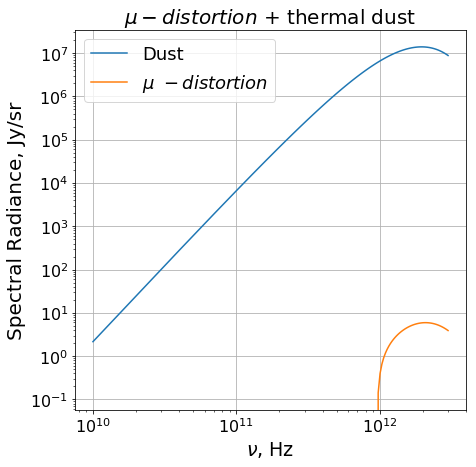

In [43]:
def Thermal_Dust_param(nu, T_D, A_D, beta_D):  # Спектр пыли c параметрами
    x = (h * nu)/(k * T_D)
    I = A_D * x**beta_D * (x**3)/(np.exp(x) - 1)
    return I


I_0 = 270 * 10**6
beta = 2.1923
mu = 2 * 10**(-8)

# Вообще в статье написано, что бетту мы знаем, а мю приняли некоторым. То есть мы знаем точно-точно это распределение? 

def mu_distortions(nu):          # То есть нет параметров, которые нужно определить? Кажется, мю это таки параметр
    x = (h * nu)/(k * T_D)
    I = I_0 * (x**4 * np.exp(x))/(np.exp(x) - 1)**2 * (1/beta - 1/x) * mu
    return I

def mu_distortions_param(nu, mu):
    x = (h * nu)/(k * T_D)
    I = I_0 * (x**4 * np.exp(x))/(np.exp(x) - 1)**2 * (1/beta - 1/x) * mu
    return I

x = np.linspace(10**10, 3 * 10**12, 100)
I_dust = Thermal_Dust(x)
I_mu = mu_distortions(x)

fig = plt.figure(figsize=(7, 7))

plt.title('$\mu-distortion$ + thermal dust', fontsize = 20)
plt.loglog(x, I_dust, label = 'Dust')
plt.loglog(x, I_mu, label = '$\mu\ - distortion$')
plt.xlabel('$\\nu$, Hz', fontsize=19)
plt.ylabel('Spectral Radiance, Jy/sr', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize = 18)
plt.grid()

# Теперь попробуем разделить два графика

def mu_dust_param(nu, T_D, A_D, beta_D, mu):
    I = Thermal_Dust_param(nu, T_D, A_D, beta_D) + mu_distortions_param(nu, mu)
    return(I)

I_tot = mu_dust_param(x, T_D, A_D, beta_D, mu)

popt, pcov = curve_fit(mu_dust_param, x, I_tot, bounds=((0, 0, 0, 0), (np.inf, np.inf, np.inf, 9 * 10**(-5))))
print(popt)

param = np.array([T_D, A_D, beta_D, mu])

print(param)
dev = list(abs(popt - param))
eps = [dev / (list(param))[n] for n, dev in enumerate(dev)]
print('Относительная ошибка', eps)

# Две пыли

In [46]:
def Thermal_Dust_param(nu, T_D, A_D, beta_D):  # Спектр пыли c параметрами
    x = (h * nu)/(k * T_D)
    I = A_D * x**beta_D * (x**3)/(np.exp(x) - 1)
    return I

def Double_Dust(nu, T_D1, T_D2, A_D, beta_D):
    x1 = (h * nu)/(k * T_D1)
    x2 = (h * nu)/(k * T_D2)
    I = A_D * x1**beta_D * (x1**3)/(np.exp(x1) - 1)  + A_D * x2**beta_D * (x2**3)/(np.exp(x2) - 1)
    return I

T_D1 = 20
T_D2 = 22

x = np.linspace(10**10, 3 * 10**12, 100)
I_double_dust = Double_Dust(x, T_D1, T_D2, A_D, beta_D)

popt, pcov = curve_fit( Double_Dust, x, I_double_dust)
print(popt)

param = np.array([T_D1, T_D2, A_D, beta_D])

print(param)

[2.20e+01 2.00e+01 1.36e+06 1.53e+00]
[2.00e+01 2.20e+01 1.36e+06 1.53e+00]
